# Driver type Classification - Supervised (one-hot-encoding)

## 1. Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder,StandardScaler
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from tensorflow.keras.utils import to_categorical

In [2]:
dataset_fcd = pd.read_csv("/kaggle/input/data-fcd/dataset_fcd_col.csv")
dataset_fcd.head()

,time,id,x,y,angle,type,speed,pos,lane,slope,...,NOx,PMx,fuel,electricity,noise,route,waiting,collision_type,collision_occurred,InvolvedParties
0,0.0,myflow.0,-194.90,-4.8,90.0,speeder,0.00,5.10,E0_0,0.0,...,1.20,0.07,837.22,0.0,55.94,rd1#1,0.0,No collision,0,Not involved
1,0.1,myflow.0,-194.90,-4.8,90.0,speeder,0.03,5.10,E0_0,0.0,...,1.20,0.07,836.72,0.0,57.21,rd1#1,0.1,No collision,0,Not involved
2,0.2,myflow.0,-194.89,-4.8,90.0,speeder,0.08,5.11,E0_0,0.0,...,1.20,0.07,837.45,0.0,58.30,rd1#1,0.2,No collision,0,Not involved
3,0.3,myflow.0,-194.87,-4.8,90.0,speeder,0.18,5.13,E0_0,0.0,...,1.21,0.07,843.70,0.0,60.13,rd1#1,0.0,No collision,0,Not involved
4,0.4,myflow.0,-194.84,-4.8,90.0,speeder,0.33,5.16,E0_0,0.0,...,1.24,0.07,866.36,0.0,62.88,rd1#1,0.0,No collision,0,Not involved


In [3]:
dataset_fcd = dataset_fcd.drop(['slope','electricity','route','eclass'],axis=1) # removing unnecessary variables

In [4]:
# ONE-HOT ENCODING
df = dataset_fcd.drop(['collision_occurred', 'collision_type', 'CO2','HC','PMx','NOx','id','type'], axis=1)

categorical_vars = ['lane','signals','InvolvedParties']

one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_vars = one_hot_encoder.fit_transform(df[categorical_vars])
encoded_categorical_df = pd.DataFrame(encoded_categorical_vars, columns=one_hot_encoder.get_feature_names_out(categorical_vars))
df = df.drop(categorical_vars, axis=1)
df = pd.concat([df, encoded_categorical_df], axis=1)

X = df.copy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset_fcd['type'])

### Naive Bayes - Baseline Model

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)

#### 1. Multinomial Naive Bayes

In [51]:
#Z-score Normalisation 
m_sc = MinMaxScaler()
X_train_mc = m_sc.fit_transform(X_train)
X_test_mc = m_sc.transform(X_test)

param_grid_mnb = param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

mnb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator=mnb, param_grid=param_grid_mnb, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train_mc, y_train)

best_params = grid_search_nb.best_params_
best_score = grid_search_nb.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:  {'alpha': 5.0} accuracy:  0.3344


Test set Accuracy:  33.59 %
Precision: 0.3258
Recall: 0.3191
F1 Score: 0.3114


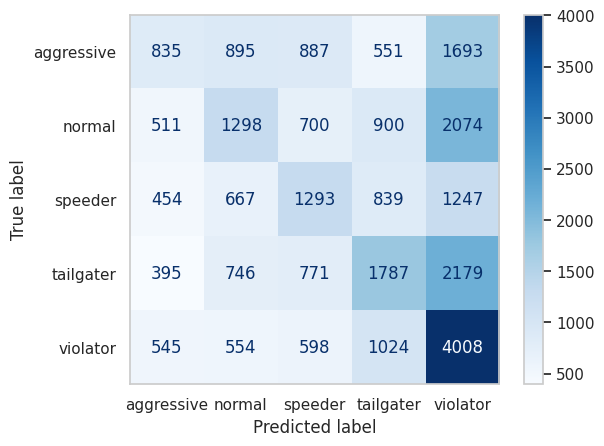

In [53]:
mnb_clf = MultinomialNB(alpha=5.0)
mnb_clf.fit(X_train_mc, y_train)
test_predict = mnb_clf.predict(X_test_mc)
acc_mnb = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_mnb,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### 2. Gausian Naive Bayes

In [56]:
#Z-score Normalisation 
z_sc = StandardScaler()
X_train_zc = z_sc.fit_transform(X_train)
X_test_zc = z_sc.transform(X_test)

param_grid_gnb = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()

grid_search_nb = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train_zc, y_train)

best_params = grid_search_nb.best_params_
best_score = grid_search_nb.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:  {'var_smoothing': 0.0657933224657568} accuracy:  0.3299


Test set Accuracy:  33.74 %
Precision: 0.3565
Recall: 0.3188
F1 Score: 0.2851


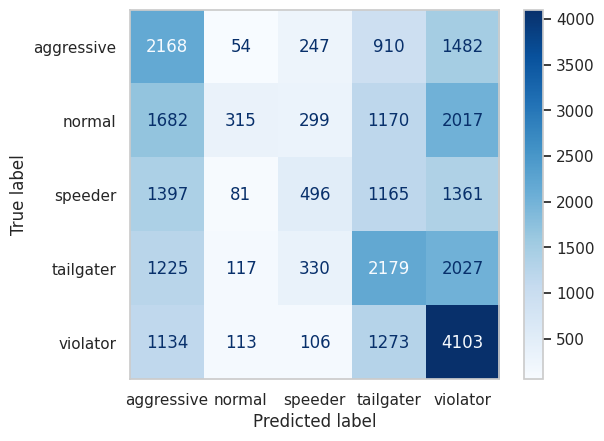

In [58]:
gnb_clf = GaussianNB(var_smoothing=0.066)
gnb_clf.fit(X_train_zc, y_train)
test_predict = gnb_clf.predict(X_test_zc)
acc_gnb = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_gnb,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

### KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold

In [59]:
knn = KNN()
param_grid_knn = {'n_neighbors':[5,10,15,20]}
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=StratifiedKFold(5), scoring='accuracy',verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_mc,y_train)

best_params = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters:  {'n_neighbors': 5} accuracy:  0.894


Test set Accuracy:  86.38 %
Precision: 0.861
Recall: 0.8619
F1 Score: 0.8603


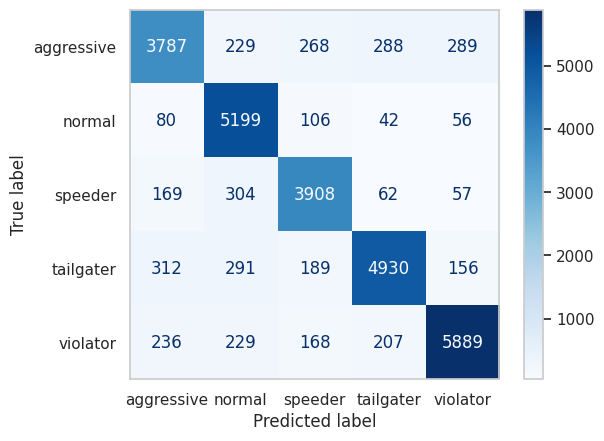

In [61]:
knn_clf = KNN(n_neighbors=5)
knn_clf.fit(X_train_zc,y_train)
test_predict = knn_clf.predict(X_test_zc)
acc_knn = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_knn,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

### Decision Tree Classifier

#### Considering all features

In [7]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [62]:
def test_env(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 10, 40)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    
    clf = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state = 42
    )
    
    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=20) 

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-08 22:16:00,076] A new study created in memory with name: no-name-d0118e80-e372-489e-8798-49a0538482eb
[I 2023-11-08 22:16:04,384] Trial 0 finished with value: 0.8337841797543236 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8337841797543236.
[I 2023-11-08 22:16:08,671] Trial 1 finished with value: 0.8433649683173243 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8433649683173243.
[I 2023-11-08 22:16:13,205] Trial 2 finished with value: 0.9277706646548207 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9277706646548207.
[I 2023-11-08 22:16:15,366] Trial 3 finished with value: 0.8969245858011747 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max

Number of finished trials:  20
Best trial:
Value:  0.9667131383511538
Params: 
    criterion: entropy
    splitter: best
    max_depth: 31
    min_samples_split: 3
    min_samples_leaf: 1


Test set Accuracy:  97.38 %
Precision: 0.9735
Recall: 0.9733
F1 Score: 0.9734


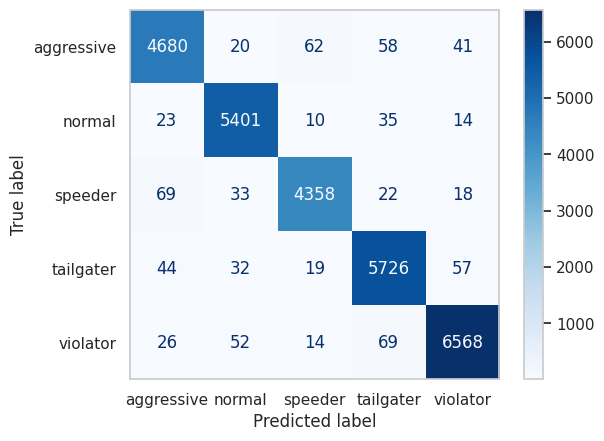

In [64]:
DT_clf = DecisionTreeClassifier(
        criterion='entropy',
        splitter='best',
        max_depth=31,
        min_samples_split=3,
        min_samples_leaf=1,
        random_state = 42
    )

DT_clf.fit(X_train,y_train)
test_predict = DT_clf.predict(X_test)
acc_DT_all = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_DT_all,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### Recursive Feature Selction Decision Tree Classifier

In [65]:
decision_tree = DecisionTreeClassifier(random_state=42)

rfecv = RFECV(estimator=decision_tree, step=1, cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(X, y)
selected_features_indices = rfecv.get_support(indices=True)

print("Optimal number of features : %d" % rfecv.n_features_)
selected_feature_names = [X.columns[i] for i in selected_features_indices]
print("Selected Features: ",selected_feature_names)

Optimal number of features : 17
Selected Features:  ['time', 'x', 'y', 'angle', 'speed', 'pos', 'acceleration', 'distance', 'CO', 'fuel', 'noise', 'lane_-E0_0', 'lane_-E1_1', 'lane_-E5_0', 'lane_-E5_1', 'signals_0', 'signals_3']


In [66]:
X_dt = X[selected_feature_names]
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(np.array(X_dt), np.array(y), test_size=0.2, random_state=42)

In [67]:
def test_env(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    
    clf = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    score = cross_val_score(clf, X_train_dt, y_train_dt, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=20) 

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-08 22:30:20,556] A new study created in memory with name: no-name-dc5f0d39-edf6-421d-8f15-eb75031ebc51
[I 2023-11-08 22:30:22,543] Trial 0 finished with value: 0.7411816920191938 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7411816920191938.
[I 2023-11-08 22:30:23,336] Trial 1 finished with value: 0.7685945369789083 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7685945369789083.
[I 2023-11-08 22:30:24,130] Trial 2 finished with value: 0.8304598240845731 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8304598240845731.
[I 2023-11-08 22:30:28,810] Trial 3 finished with value: 0.948689949537137 and parameters: {'criterion': 'entropy', 'splitter': 'best',

Number of finished trials:  20
Best trial:
Value:  0.9641813244193693
Params: 
    criterion: entropy
    splitter: best
    max_depth: 24
    min_samples_split: 2
    min_samples_leaf: 1


Test set Accuracy:  97.04 %
Precision: 0.9701
Recall: 0.9695
F1 Score: 0.9698


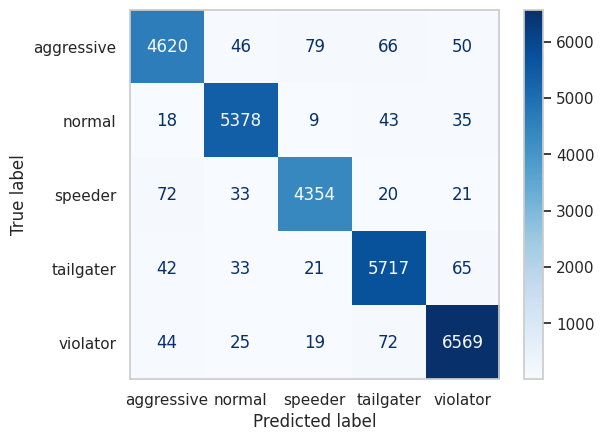

In [69]:
DT_clf = DecisionTreeClassifier(
        criterion='entropy',
        splitter='best',
        max_depth=24,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state = 42
    )

DT_clf.fit(X_train_dt,y_train_dt)
test_predict = DT_clf.predict(X_test_dt)
acc_DT_sel = accuracy_score(test_predict,y_test_dt)*100
precision = precision_score(y_test_dt, test_predict,average='macro')
recall = recall_score(y_test_dt, test_predict,average='macro')
f1 = f1_score(y_test_dt, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test_dt, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test_dt)))

print('Test set Accuracy: ', f'{round(acc_DT_sel,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

### Random Forest Classifier

#### Considering all features

In [8]:
import optuna
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [10]:
def test_env(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score    

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=50) 

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-09 04:19:44,964] A new study created in memory with name: no-name-adf0979d-4192-40a5-8e87-d4b53bfc4375
[I 2023-11-09 04:21:04,885] Trial 0 finished with value: 0.8663606729896823 and parameters: {'n_estimators': 209, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8663606729896823.
[I 2023-11-09 04:23:04,655] Trial 1 finished with value: 0.9109314184965582 and parameters: {'n_estimators': 272, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9109314184965582.
[I 2023-11-09 04:26:06,116] Trial 2 finished with value: 0.9028533057732997 and parameters: {'n_estimators': 431, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9109314184965582.
[I 2023-11-09 04:27:42,332] Trial 3 finished with value: 0.8863236654247733 and parameters: {'n_estimators': 241, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 1 with value

Number of finished trials:  50
Best trial:
Value:  0.9234446944322311
Params: 
    n_estimators: 439
    max_depth: 35
    min_samples_split: 4
    min_samples_leaf: 1


Test set Accuracy:  93.48 %
Precision: 0.9333
Recall: 0.9343
F1 Score: 0.9334


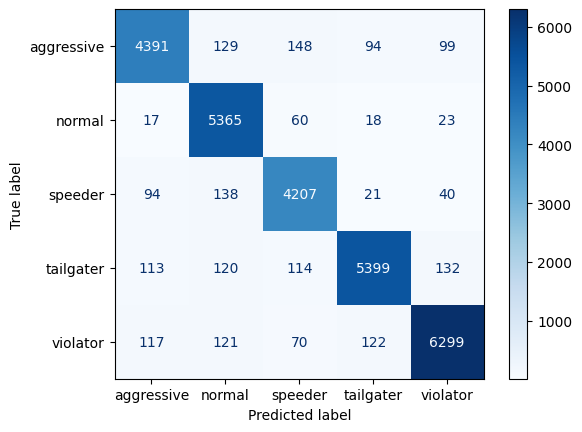

In [16]:
rf_clf = RandomForestClassifier(
        n_estimators=439,
        max_depth=35,
        min_samples_split=4,
        min_samples_leaf=1,
        random_state=42
    )

rf_clf.fit(X_train,y_train)
test_predict = rf_clf.predict(X_test)
acc_rf_all = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_rf_all,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

In [15]:
X_sample, _, y_sample, _ = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42) 
# did sampling due to more that 2 hrs computiontional time

random_forest = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=random_forest, step=3, cv=StratifiedKFold(3), n_jobs=-1, scoring='accuracy')

rfecv.fit(X_sample, y_sample)
selected_features_indices = rfecv.get_support(indices=True)

print("Optimal number of features : %d" % rfecv.n_features_)
selected_feature_names = [X.columns[i] for i in selected_features_indices]
print("Selected Features: ",selected_feature_names)

Optimal number of features : 6
Selected Features:  ['time', 'x', 'y', 'speed', 'pos', 'noise']


In [16]:
# selected rfcv features of Decsiion tree classifier as RFCV
selected_feature = ['time', 'x', 'y','speed', 'pos', 'noise']
X_dt = X[selected_feature]
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(np.array(X_dt), np.array(y), test_size=0.2, random_state=42)

In [17]:
def test_env(trial):
    n_estimators = trial.suggest_int('n_estimators', 150, 350)
    max_depth = trial.suggest_int('max_depth', 35, 55)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 7)    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=1,
        random_state=42
    )
    
    score = cross_val_score(clf, X_train_dt, y_train_dt, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=20) 

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-10 03:45:43,016] A new study created in memory with name: no-name-e1fc7d83-4df5-4b7c-ae3e-0e41000f9a58
[I 2023-11-10 03:47:39,116] Trial 0 finished with value: 0.9841625421584828 and parameters: {'n_estimators': 231, 'max_depth': 50, 'min_samples_split': 4}. Best is trial 0 with value: 0.9841625421584828.
[I 2023-11-10 03:49:25,680] Trial 1 finished with value: 0.983206284546981 and parameters: {'n_estimators': 215, 'max_depth': 40, 'min_samples_split': 6}. Best is trial 0 with value: 0.9841625421584828.
[I 2023-11-10 03:51:11,512] Trial 2 finished with value: 0.9820496696868408 and parameters: {'n_estimators': 214, 'max_depth': 54, 'min_samples_split': 7}. Best is trial 0 with value: 0.9841625421584828.
[I 2023-11-10 03:53:11,578] Trial 3 finished with value: 0.9843082570866436 and parameters: {'n_estimators': 241, 'max_depth': 51, 'min_samples_split': 4}. Best is trial 3 with value: 0.9843082570866436.
[I 2023-11-10 03:55:25,966] Trial 4 finished with value: 0.984372009363

Number of finished trials:  20
Best trial:
Value:  0.9845996877723874
Params: 
    n_estimators: 323
    max_depth: 46
    min_samples_split: 4


Test set Accuracy:  98.79 %
Precision: 0.9876
Recall: 0.9878
F1 Score: 0.9877


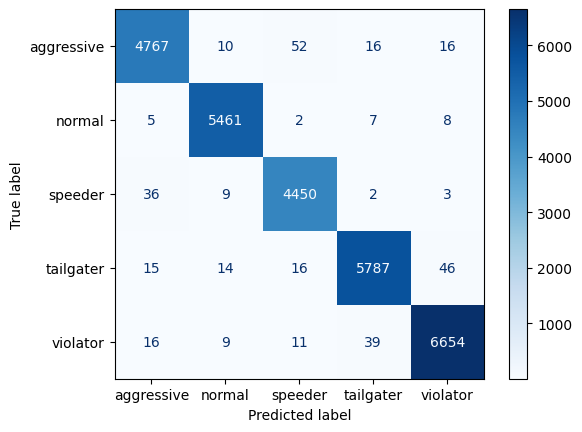

In [20]:
rf_clf = RandomForestClassifier(
        n_estimators=323,
        max_depth=46,
        min_samples_split=4,
        min_samples_leaf=1,
        random_state=42
    )

rf_clf.fit(X_train_dt,y_train_dt)
test_predict = rf_clf.predict(X_test_dt)
acc_rf_sel = accuracy_score(test_predict,y_test_dt)*100
precision = precision_score(y_test_dt, test_predict,average='macro')
recall = recall_score(y_test_dt, test_predict,average='macro')
f1 = f1_score(y_test_dt, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test_dt, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test_dt)))

print('Test set Accuracy: ', f'{round(acc_rf_sel,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

### Principal Component Analysis - PCA (for dimentionality reduction) 

In [107]:
from sklearn.decomposition import PCA
m_sc = MinMaxScaler()
X_train_mc = m_sc.fit_transform(X_train)
X_test_mc = m_sc.transform(X_test)

pca_fcd = PCA(n_components=69)
X_train_fcd = pca_fcd.fit_transform(X_train_mc)
X_test_fcd = pca_fcd.transform(X_test_mc)
pca_table_fcd = pd.DataFrame([round(i,3) for i in pca_fcd.explained_variance_ratio_*100],
                      columns= ['Explained Variance %'],
                      index = ['PC'+str(x) for x in range(1,len(pca_fcd.explained_variance_ratio_)+1)])
pca_table_fcd =pca_table_fcd.T
pca_table_fcd.columns.name = 'Table 1'
pca_table_fcd

cumulative_variance_ratio = np.cumsum(pca_fcd.explained_variance_ratio_*100)
n_components_95 = np.argmax(cumulative_variance_ratio >= 95.5) + 1  
n_components_95

30

Text(0.5, 1.0, 'Scree plot')

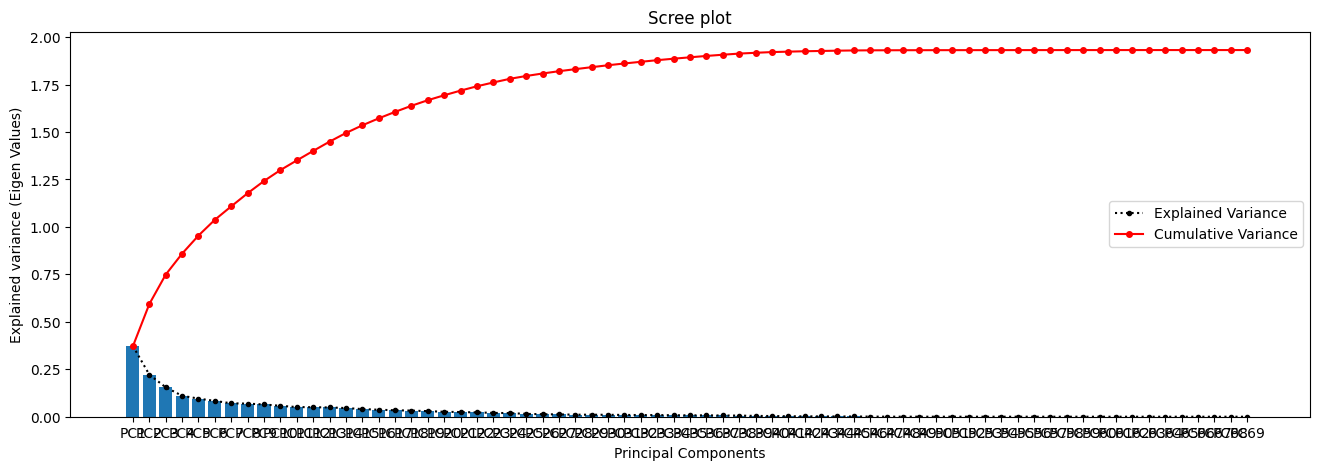

In [108]:
# scree-plot cumulative variance
fig, ax1= plt.subplots(figsize=(16,5))
ax1.bar(range(1,len(pca_fcd.explained_variance_)+1),pca_fcd.explained_variance_ , 
        tick_label = ['PC' + str(i) for i in range(1,len(pca_fcd.explained_variance_)+1)])
ax1.plot(range(1,len(pca_fcd.explained_variance_)+1),pca_fcd.explained_variance_, c='black', marker = '.',
         linestyle= 'dotted',
        label = 'Explained Variance')

ax1.plot(range(1,len(pca_fcd.explained_variance_)+1),np.cumsum(pca_fcd.explained_variance_),c='r',
         label='Cumulative Variance', 
         marker='.', linestyle='solid', markersize=8)
ax1.legend(loc='center right')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained variance (Eigen Values)')
ax1.set_title('Scree plot')

#### As sceen from the scree-plot and PC table, we can see that first 30 PC's explains arround 95% of the dataset. 

In [109]:
pca_fcd = PCA(n_components=30)
X_train_fcd = pca_fcd.fit_transform(X_train)
X_test_fcd = pca_fcd.transform(X_test)

#### Multinomial Naive Bayes - PCA

In [110]:
m_sc = MinMaxScaler()
X_train_mc = m_sc.fit_transform(X_train_fcd)
X_test_mc = m_sc.transform(X_test_fcd)

param_grid_mnb = param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
mnb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator=mnb, param_grid=param_grid_mnb, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train_mc, y_train)

best_params = grid_search_nb.best_params_
best_score = grid_search_nb.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:  {'alpha': 0.1} accuracy:  0.2521


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set Accuracy:  24.89 %
Precision: 0.1337
Recall: 0.2037
F1 Score: 0.0892


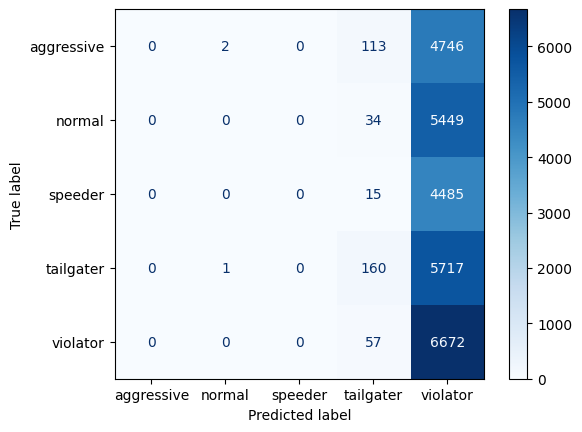

In [118]:
mnb_clf = MultinomialNB(alpha=0.1)
mnb_clf.fit(X_train_mc, y_train)
test_predict = mnb_clf.predict(X_test_mc)
acc_mnb = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_mnb,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### Gausian Naive Bayes - PCA 

In [114]:
param_grid_gnb = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()

grid_search_nb = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train_fcd, y_train)

best_params = grid_search_nb.best_params_
best_score = grid_search_nb.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:  {'var_smoothing': 6.579332246575682e-08} accuracy:  0.3714


Test set Accuracy:  37.24 %
Precision: 0.3636
Recall: 0.3635
F1 Score: 0.3486


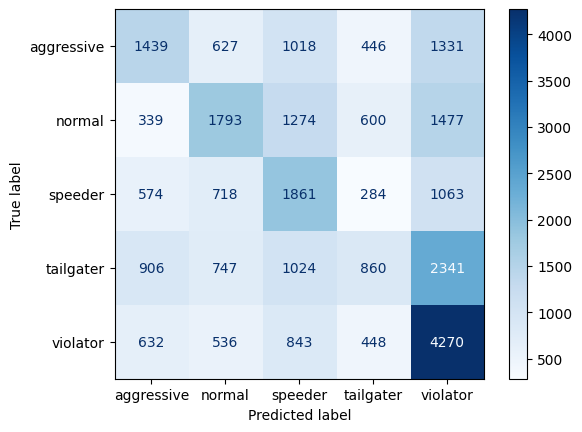

In [116]:
gnb_clf = GaussianNB(var_smoothing=6.5793e-08)
gnb_clf.fit(X_train_fcd, y_train)
test_predict = gnb_clf.predict(X_test_fcd)
acc_gnb = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_gnb,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### KNN - PCA

In [119]:
knn = KNN()
param_grid_knn = {'n_neighbors':[5,10,15,20]}
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=StratifiedKFold(5), scoring='accuracy',verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_fcd,y_train)

best_params = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_

print("Best parameters: ",best_params, "accuracy: " ,round(best_score,4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters:  {'n_neighbors': 5} accuracy:  0.8107


Test set Accuracy:  83.05 %
Precision: 0.827
Recall: 0.8279
F1 Score: 0.8266


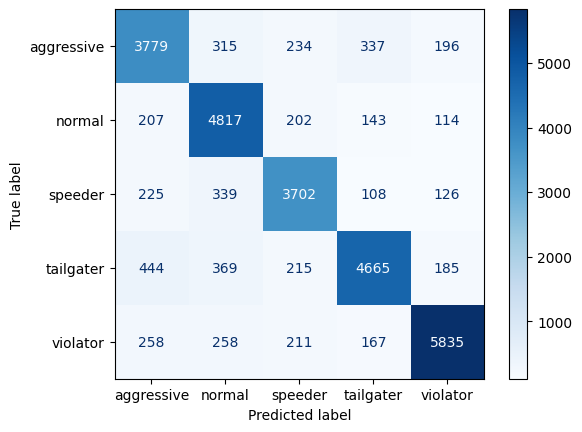

In [120]:
knn_clf = KNN(n_neighbors=5)
knn_clf.fit(X_train_fcd,y_train)
test_predict = knn_clf.predict(X_test_fcd)
acc_knn = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_knn,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### Decision Tree Classifier - PCA

In [123]:

def test_env(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 20, 60)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    
    clf = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=1,
        random_state = 42
    )
    
    score = cross_val_score(clf, X_train_fcd, y_train, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=30) 


print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-09 20:26:19,766] A new study created in memory with name: no-name-dcd69cfb-162b-4b67-a50b-9ddb0a794f1f
[I 2023-11-09 20:26:33,780] Trial 0 finished with value: 0.911514246276455 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 31, 'min_samples_split': 14}. Best is trial 0 with value: 0.911514246276455.
[I 2023-11-09 20:26:55,794] Trial 1 finished with value: 0.9312860187902234 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 52, 'min_samples_split': 8}. Best is trial 1 with value: 0.9312860187902234.
[I 2023-11-09 20:27:17,791] Trial 2 finished with value: 0.9269874120283937 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 47, 'min_samples_split': 11}. Best is trial 1 with value: 0.9312860187902234.
[I 2023-11-09 20:27:39,499] Trial 3 finished with value: 0.933954430228981 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 37, 'min_samples_split': 5}. Best is trial 3 with value: 0.

Number of finished trials:  30
Best trial:
Value:  0.9367594445659547
Params: 
    criterion: entropy
    splitter: best
    max_depth: 60
    min_samples_split: 2


Test set Accuracy:  94.67 %
Precision: 0.9461
Recall: 0.9461
F1 Score: 0.9461


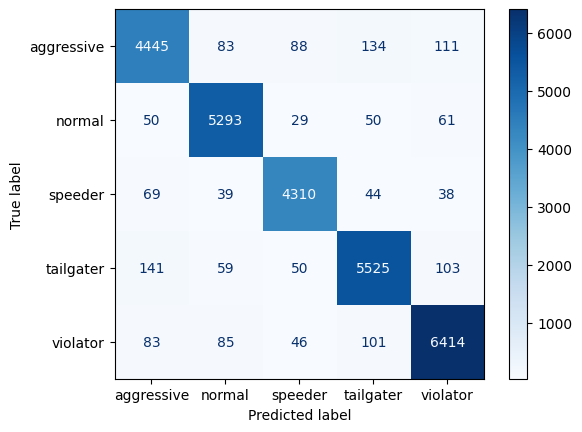

In [124]:
DT_clf = DecisionTreeClassifier(
        criterion='entropy',
        splitter='best',
        max_depth=60,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state = 42
    )

DT_clf.fit(X_train_fcd,y_train)
test_predict = DT_clf.predict(X_test_fcd)
acc_DT_all = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_DT_all,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()

#### Random Forest Classifier - PCA

In [126]:
def test_env(trial):
    n_estimators = trial.suggest_int('n_estimators', 150, 350)
    max_depth = trial.suggest_int('max_depth', 35, 60)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 7)    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=1,
        random_state=42
    )
    
    score = cross_val_score(clf, X_train_fcd, y_train, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study = optuna.create_study(direction='maximize')

study.optimize(test_env, n_trials=20) 

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-09 21:52:26,503] A new study created in memory with name: no-name-c92c01c7-bef2-49a5-aa55-09373224491f
[I 2023-11-09 21:58:57,661] Trial 0 finished with value: 0.9380982112768379 and parameters: {'n_estimators': 243, 'max_depth': 53, 'min_samples_split': 4}. Best is trial 0 with value: 0.9380982112768379.
[I 2023-11-09 22:04:43,797] Trial 1 finished with value: 0.9344826534271011 and parameters: {'n_estimators': 218, 'max_depth': 49, 'min_samples_split': 7}. Best is trial 0 with value: 0.9380982112768379.
[I 2023-11-09 22:12:49,300] Trial 2 finished with value: 0.9380799967553012 and parameters: {'n_estimators': 311, 'max_depth': 44, 'min_samples_split': 4}. Best is trial 0 with value: 0.9380982112768379.
[I 2023-11-09 22:20:46,907] Trial 3 finished with value: 0.93836231955821 and parameters: {'n_estimators': 306, 'max_depth': 35, 'min_samples_split': 4}. Best is trial 3 with value: 0.93836231955821.
[I 2023-11-09 22:25:48,155] Trial 4 finished with value: 0.937305886432721

Number of finished trials:  20
Best trial:
Value:  0.93836231955821
Params: 
    n_estimators: 306
    max_depth: 35
    min_samples_split: 4


Test set Accuracy:  94.98 %
Precision: 0.9483
Recall: 0.9491
F1 Score: 0.9486


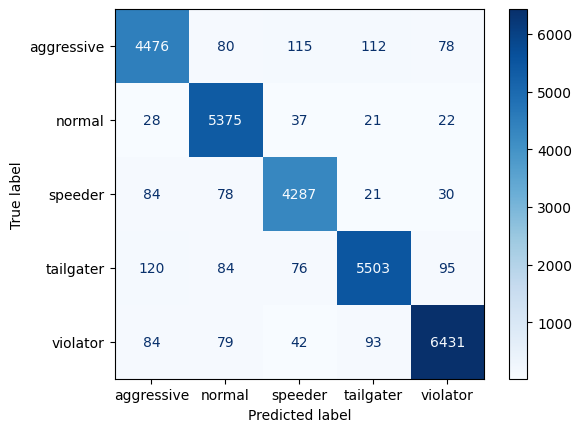

In [133]:
rf_clf = RandomForestClassifier(
        n_estimators=306,
        max_depth=35,
        min_samples_split=4,
        min_samples_leaf=1,
        random_state=42
    )

rf_clf.fit(X_train_fcd,y_train)
test_predict = rf_clf.predict(X_test_fcd)
acc_rf_sel = accuracy_score(test_predict,y_test)*100
precision = precision_score(y_test, test_predict,average='macro')
recall = recall_score(y_test, test_predict,average='macro')
f1 = f1_score(y_test, test_predict,average='macro')
conf_matrix = confusion_matrix(y_test, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test)))

print('Test set Accuracy: ', f'{round(acc_rf_sel,2)} %')
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False) 
plt.show()